### 출처
https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads.


어렵다,,,,,

In [2]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 16.8MB/s 
     |████████████████████████████████| 952kB 29.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=71ddd592583fabe154d6ad0a2822ff9832b85519b888889969fbcf509aff3c68
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
! pip install albumentations

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [4]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null 

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-3q09r93h
ERROR: Operation cancelled by user


In [5]:
DIR_INPUT = '/content/drive/MyDrive/Colab Notebooks/FasterRCNN/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [6]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape  #image_id, width, height, bbox, source

(147793, 5)

In [4]:
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [7]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [8]:
#bbox에 있는 x, y, w, h를 새 열 만들어서 넣어줌, 그리고 bbox drop
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [7]:
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [9]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [10]:
tmp = train_df['image_id'].duplicated()
tmp

0         False
1          True
2          True
3          True
4          True
          ...  
147788     True
147789     True
147790     True
147791     True
147792     True
Name: image_id, Length: 147793, dtype: bool

In [10]:
valid_ids

array(['bbce58f71', 'b45096c1e', 'b3c96d5ad', '1be796d9d', 'ba9133208',
       'ac891ac35', 'a5904a10b', 'ea0e9e846', '92f3b252f', '59d43a53f',
       '290ae67be', '8afea785a', '44b7163ea', 'd1f73158a', 'fabaeac81',
       'b57f67edf', 'c8defc0d1', '5f5181592', '38b19d4f5', 'f233cfd8b',
       '2391f283f', '07479da31', '5e182e37e', 'ce3999eb9', '03d831c0d',
       'e721e6416', '228f94f80', '4b127eb47', '6f119c82d', 'a6c205e19',
       '2c836cccb', 'f54ff03a2', '09f97e0cf', 'b46dce732', '9658b9c3c',
       'f5b320e47', '6b4169a72', 'f415daf80', '99886a700', '0c2d20111',
       '1b3376c60', '5e30f8f4d', 'ab81b2342', 'abcb46fc1', 'e05767cda',
       'ca664da7d', '93c9d721e', 'f84383b38', '56105ed87', '18df0fea9',
       '14d024cc4', '89fb3f19c', 'aa82bfd6a', '42f5fe6a5', 'd39457b35',
       'b7c9166b6', 'd011146e3', '69e509038', '3ee6fd90a', 'aec95891a',
       '6b8416819', 'c022ddc42', 'a88930f1f', '3b2183a3c', '7ad46c7f4',
       '69a211ccf', '3ae057d35', '7bf6e7991', '16a0dc111', '5a56

In [11]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [12]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [13]:
class WheatDataset(Dataset):
    #Dataset은 추상 클래스임, getitem, len overwrite
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        #인덱스 주면 image, target, image_id 줌
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR) #컬러로 읽음
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 #정규화

        boxes = records[['x', 'y', 'w', 'h']].values #박스 크기만큼 자르는거 같음
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [14]:
#Albumentations : Python library for image augmentation.
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
        #Pascal VOC Bounding box :(xmin-top left, ymin-top left,xmax-bottom right, ymax-bottom right)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [16]:
num_classes = 2  # wheat이랑 배경

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [17]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property #getter   setter는 그냥 setter
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


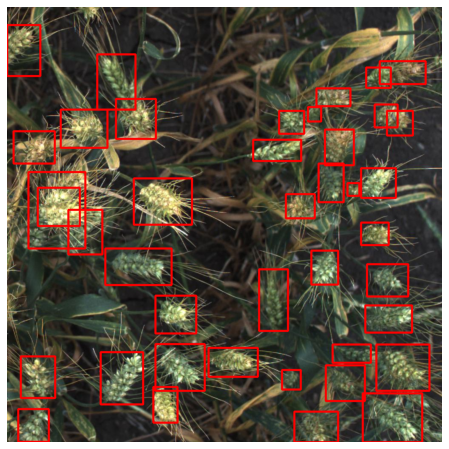

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
#서브 플롯의 축을 off    
ax.set_axis_off()
ax.imshow(sample)


In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 2

In [24]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 1.0973765111379556
Iteration #100 loss: 0.838273750619812
Iteration #150 loss: 0.820925162546438
Epoch #0 loss: 1.0455406376063436
Iteration #200 loss: 0.9145994388990668
Iteration #250 loss: 0.8955608587672488
Iteration #300 loss: 0.7133189318160258
Epoch #1 loss: 0.8964907605942336


In [26]:
images, targets, image_ids = next(iter(valid_data_loader))

In [27]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [28]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [29]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


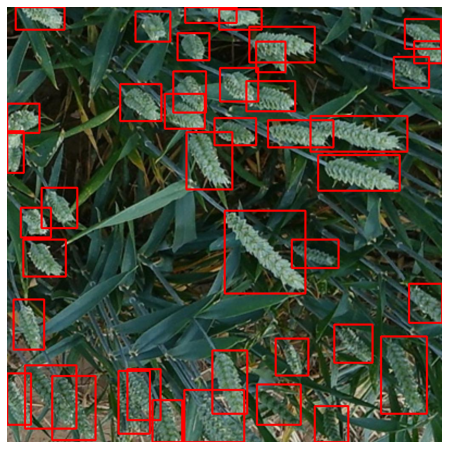

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)


In [31]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')